In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances

In [16]:
# Load dataset
df = pd.read_csv("electricvehicles.csv")

# Drop unused column
df = df.drop(columns=["Segment"])

# Clean and preprocess
df = df.dropna(subset=[
    "AccelSec", "TopSpeed_KmH", "Range_Km", "Efficiency_WhKm",
    "Charge_KmH", "RapidCharge", "Seats", "PriceEuro"
])

# Encode categorical values
powertrain_map = {"AWD": 1.0, "RWD": 0.75, "FWD": 0.5}
df["PowerTrainScore"] = df["PowerTrain"].map(powertrain_map).fillna(0.5)
df["RapidChargeScore"] = df["RapidCharge"].apply(lambda x: 1 if str(x).lower() == "yes" else 0)

# Select numerical columns for scoring (excluding PriceEuro from score)
score_columns = [
    "AccelSec", "TopSpeed_KmH", "Range_Km", "Efficiency_WhKm",
    "Charge_KmH", "Seats", "RapidChargeScore", "PowerTrainScore"
]

# Normalize numerical features
scaler = MinMaxScaler()
norm_features = scaler.fit_transform(df[score_columns])

# Define ideal (best possible) vehicle: min(AccelSec, Efficiency), max(all others)
ideal_point = []
for col in score_columns:
    if col in ["AccelSec", "Efficiency_WhKm"]:
        ideal_point.append(0.0)  # min is best after normalization
    else:
        ideal_point.append(1.0)  # max is best after normalization

# Compute Euclidean distance to ideal vehicle
distances = euclidean_distances(norm_features, [ideal_point]).flatten()
df["DistanceToIdeal"] = distances

# Compute value score as inverse of distance per euro
# Add small constant to avoid division by zero
epsilon = 1e-6
df["ValueScore"] = 1 / (df["DistanceToIdeal"] + epsilon) / df["PriceEuro"]

# Sort and show top result
top_vehicle = df.sort_values("ValueScore", ascending=False).iloc[0]

# Output top vehicle details
print("Top Value-per-Euro Vehicle (Euclidean method):")
print(top_vehicle[["Brand", "Model", "ValueScore"]])


Top Value-per-Euro Vehicle (Euclidean method):
Brand                 SEAT
Model         Mii Electric
ValueScore        0.000024
Name: 44, dtype: object


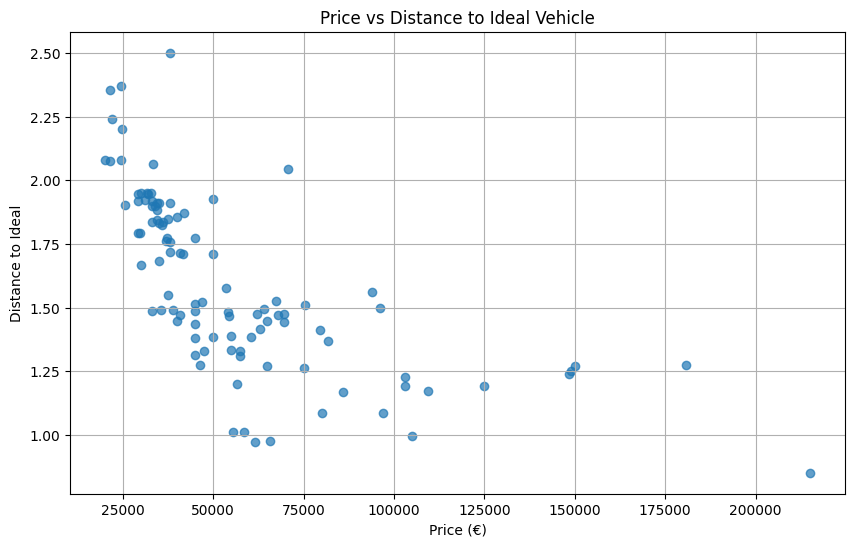

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df["PriceEuro"], df["DistanceToIdeal"], alpha=0.7)
plt.title("Price vs Distance to Ideal Vehicle")
plt.xlabel("Price (€)")
plt.ylabel("Distance to Ideal")
plt.grid(True)
plt.show()